In [1]:
import numpy as np
from scipy.special import erf, erfinv
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [2]:
NE, NI, N_syl, N_HVC_per_syl = 600, 150, 3, 3
N_HVC = N_syl * N_HVC_per_syl

In [3]:
peak_rate, kernel_width = 150, 20

In [4]:
T_rend = 600 # Each rendition
N_rend = 25 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

In [5]:
# Syllables and time stamps
syl = rng.normal(1, 3, size=(N_syl, NE))#.clip(min=0)
tsyl_start, tsyl_end, burst_ts = generate_syl_time(T, T_burn, T_rend, N_syl, N_HVC)
save_W_ts = np.round(tsyl_end[-1]).astype(int)
# burst_ts -= 20

In [6]:
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

In [7]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
# aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

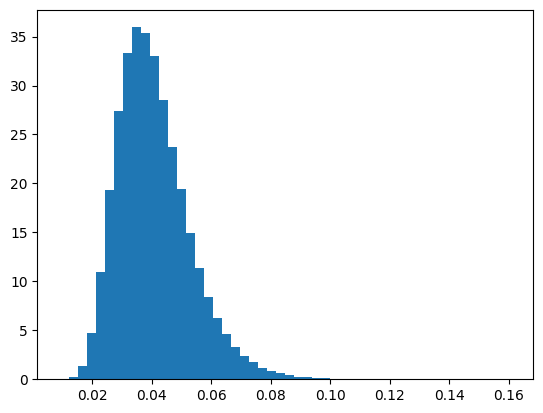

In [8]:
gen = lognormal_gen
# gen = const_gen
c = 1
JEE0, JEI0, JIE0, JII0 = np.array([1, 0.8, 1.25, 0.9])
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.3
# sEE *= 1.3
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE) / np.sqrt(NE)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI) / np.sqrt(NI)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE) / np.sqrt(NE)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII) / np.sqrt(NI)
plt.hist(JEE.flatten(), bins=50, density=True);

In [9]:
rEmax, rImax, thE, thI, sE, sI = 40, 100, -5, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

In [10]:
w0_mean, w0_std = 1/N_HVC, 0/N_HVC
w_inh, wI = w0_mean*0.2, 0.0
tauE, tauI, dt = 40, 10, 1

net = EINetRecPlasticity(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, 
                         JEE=JEE, JEI=JEI, JIE=JIE, JII=JII, w_inh=w_inh, wI=wI, 
                         w0_std=w0_std, cW=0.1)

In [11]:
def bilin_hebb(net, aiv_post, aiv_pre, hvc_in, lr, w0_mean, tauW):
    # lr < 0, anti-Hebbian
    aux = (aiv_post[:,None] - 1) * (aiv_pre[None,:] - 1)
    dW = lr * aux - (net.JEE - w0_mean)
    net.JEE = np.clip(net.JEE + dW / tauW, a_min=0, a_max=None)

In [12]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
_ = net.sim(rE0, rI0, rH, aud, save_W_ts, T, dt, 1, bilin_hebb,
            lr=-5e-1, asyn=20, w0_mean=JEE, tauW=1e5)
rE, rI, Ws, mean_HVC_input, hE = _

100%|████████████████████████████████████| 15499/15499 [00:33<00:00, 465.02it/s]


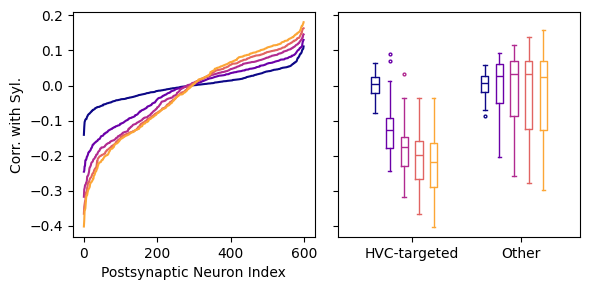

In [29]:
J_corrs = [correlation(_.T, syl) for _ in Ws]
cmap = plt.get_cmap('plasma')
p, q = 0, 1 # syl idx and hvc idx
idx = [0, 5, 10, 20, -1]
filt = np.where(net.W.toarray() != 0)
fig, ax = plt.subplots(1, 2, sharey='all', figsize=(6, 3))
for i, j in enumerate(idx):
    color = cmap(i/len(idx))
    ax[0].plot(np.sort(J_corrs[i][:,p]), c=color)
    sig = J_corrs[i][filt[0][filt[1]==q],p]
    bg = J_corrs[i][~filt[0][filt[1]==q],p]
    ax[1].boxplot([sig, bg], positions=[i/len(idx), 1.5+i/len(idx)],
                  widths=0.5/len(idx), flierprops=dict(ms=2, mec=color), 
                  boxprops=dict(color=color), capprops=dict(color=color),
                  whiskerprops=dict(color=color), medianprops=dict(color=color))
ax[0].set(xlabel='Postsynaptic Neuron Index', ylabel='Corr. with Syl.')
ax[1].set(xticks=[0.5, 2], xticklabels=['HVC-targeted', 'Other'])
fig.tight_layout()

## Test Model with Unmatched Auditory Feedback

In [14]:
N_rend_test = 1
T_test = T_burn + T_rend * N_rend_test
t_test_start, t_test_end = tsyl_start[:,:N_rend_test], tsyl_end[:,:N_rend_test]
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH_ = generate_HVC(T_test, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)
rH_null = np.zeros_like(rH_)
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
noise = 1

### Mismatch with completely independent patterns

In [15]:
idx_si = np.arange(syl.shape[0]) # shuffle index
syl_sp = syl.copy() # shuffle syllable patterns (randomize)
rng.shuffle(idx_si, axis=0)
while (idx_si == np.arange(len(idx_si))).any():
    rng.shuffle(idx_si, axis=0)
# idx_si[1:5] = np.arange(1, 5)
syl_si = syl[idx_si]
rng.shuffle(syl_sp, axis=1)

aud_si = generate_discrete_aud(T_test, NE, t_test_start, t_test_end, syl_si)
aud_sp = generate_discrete_aud(T_test, NE, t_test_start, t_test_end, syl_sp)
aud_pb = aud[:T_test].copy()
# aud_si[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))
# aud_sp[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))
# aud_pb[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))
aud_df = rng.normal(0, 1, size=aud_si.shape)

In [16]:
test_names = ('Singing\ncorrect', 'Singing\nshuf. index', 
              'Singing\nshuf. pattern', 'Playback\n', 'Singing\ndeafen')
# plasticity function is None and lr is 0 by default
test0 = net.sim(rE0, rI0, rH_, aud[:T_test], [], T_test, dt, noise)
test_si = net.sim(rE0, rI0, rH_, aud_si, [], T_test, dt, noise)
test_sp = net.sim(rE0, rI0, rH_, aud_sp, [], T_test, dt, noise)
test_pb = net.sim(rE0, rI0, rH_null, aud_pb, [], T_test, dt, noise)
test_df = net.sim(rE0, rI0, rH_, aud_df, [], T_test, dt, noise)
# just want rE and rI
test0, test_si, test_sp = test0[:2], test_si[:2], test_sp[:2]
test_pb, test_df = test_pb[:2], test_df[:2]
tests_all = (test0, test_si, test_sp, test_pb, test_df)

100%|█████████████████████████████████████| 1099/1099 [00:00<00:00, 4498.57it/s]


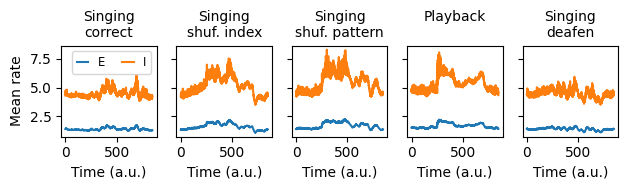

In [17]:
ti, tj = T_burn//2, T_burn+T_rend
fig, ax = plot_tests_mean(tests_all, test_names, ti, tj)

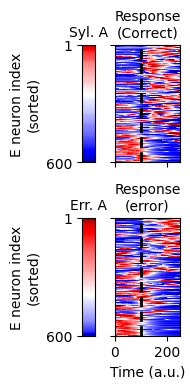

In [18]:
fig, ax = plot_raster_cmp_syl_dsyl(test0, test_sp, syl[0], syl_sp[0]-syl[0], 
                                   tsyl_start[0,0], tsyl_end[0,0])

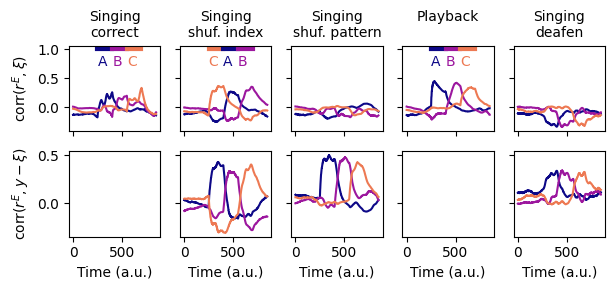

In [19]:
ti, tj = T_burn//2, T_burn + T_rend
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
aux = [(i, *ts[i]) for i in (0, 1, 2)] # for non-shuffled
fig, ax = plot_tests_corrs(tests_all, (syl, syl_si, syl_sp, syl, None), syl, test_names,
                           ti, tj, tid_perturb_input=(1, 2, 4), 
                           syl_order={1: [(j, *ts[i]) for i, j in enumerate(idx_si)],
                                      0: aux, 3: aux}, y=1)

406 194
114 36


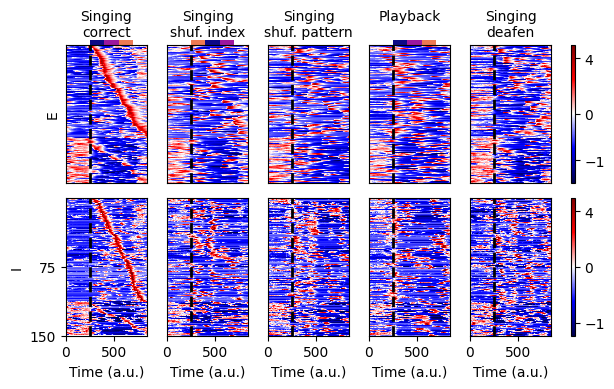

In [20]:
ti, tj = T_burn//2, T_burn + T_rend #int(tsyl_end[2,0])
fig, ax = plot_tests_raster(tests_all, test_names, ti, tj, T_burn, plot_inh=True, 
                            syl_order={1: [(j, *ts[i]) for i, j in enumerate(idx_si)],
                                      0: aux, 3: aux})

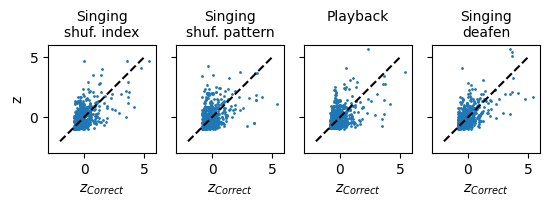

In [21]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_ctrl_vs_nonctrl(tests_all, test_names, ti, tj)

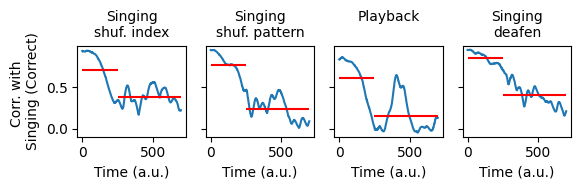

In [22]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_corr_ctrl_nonctrl(tests_all, test_names, ti, tj, T_burn)

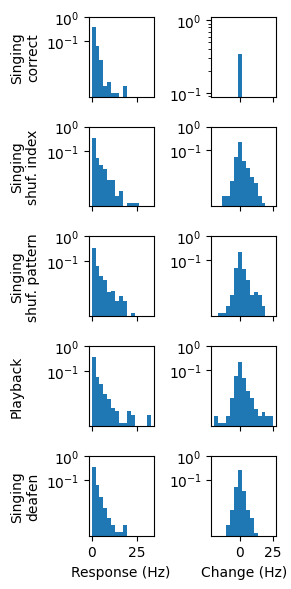

In [23]:
ti, tj = T_burn, int(tsyl_end[0,0])
fig, ax = plot_rate_and_change_dists(tests_all, test_names, ti, tj)

In [24]:
# Mutual information
r, x = test_sp[0][T_burn:int(tsyl_end[0,0])].mean(axis=0), (syl - syl_sp)[0]
joint_p = np.histogram2d(x, r, bins=50, density=True) # row is vertical dim.
joint_p[0][:] += 1e-100
p_r = np.histogram(r, bins=joint_p[2], density=True)
p_r[0][:] += 1e-100
p_x = np.histogram(x, bins=joint_p[1], density=True)
p_x[0][:] += 1e-100
dr, dx = joint_p[2][1] - joint_p[2][0], joint_p[1][1] - joint_p[1][0]
h_x_given_r = -np.sum(joint_p[0] * (np.log(joint_p[0]) - np.log(p_r[0][None,:]))) * dr * dx
h_x = -np.sum(p_x[0] * np.log(p_x[0])) * dx
h_r = -np.sum(p_r[0] * np.log(p_r[0])) * dr
h_x, h_r, h_x - h_x_given_r

(2.813961416161205, 1.4917785125620135, 0.6781217068517824)

### Mismatch with perturbed patterns

In [25]:
perturb_type = 'SNR'
# perturb_type = 'ADD'
perturb_param = np.linspace(0, 1, num=11) 
tests, ovlps, corrs = [], [], []

for pm in perturb_param:
    eps = rng.standard_normal(size=syl.shape)
    syl_ = syl.copy()
    if perturb_type == 'SNR':
        mean_syl, std_syl = syl.mean(), syl.std()
        syl_ = (syl - mean_syl) / std_syl * (1 - pm) + np.sqrt(pm * (2 - pm)) * eps
        syl_ = syl_ * std_syl + mean_syl
    elif perturb_type == 'ADD':
        syl_ = syl + pm * eps
    else:
        raise NotImplementedError
    aud_ = generate_discrete_aud(T_test, NE, t_test_start, t_test_end, syl_)
    tests.append(net.sim(rE0, rI0, rH_, aud_, [], T_test, dt, noise))
    ovlps.append(tests[-1][-0] @ syl.T)
    corrs.append(correlation(tests[-1][0], np.abs(syl_ - syl), dim=2))

100%|█████████████████████████████████████| 1099/1099 [00:00<00:00, 4667.49it/s]


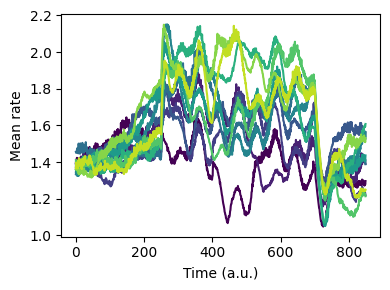

In [26]:
fig, ax = plt.subplots(1, sharey='all', sharex='all', figsize=(4, 3))
# for i in range(ax.shape[1]):
#     ax[-1,i].set(xlabel='Time (a.u.)')
cmap = colormaps.get_cmap('viridis')
for i, (pm, test) in enumerate(zip(perturb_param, tests)):
    ax.plot(test[0][T_burn//2:T_burn+T_rend].mean(axis=1), c=cmap(i/len(perturb_param)))
    
ax.set(xlabel='Time (a.u.)', ylabel='Mean rate')
fig.tight_layout()

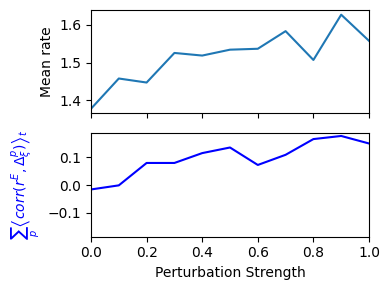

In [27]:
fig, ax = plt.subplots(2, sharex='all', figsize=(4, 3))
# ax = [*ax, ax[1].twinx()]
ax[0].plot(perturb_param, list(map(lambda x: x[0].mean(), tests)))
ax[1].plot(perturb_param, list(map(lambda x: x.sum(axis=1).mean(), corrs)), 
           color='b', label='Corr.')
# ax[2].plot(perturb_param, list(map(lambda x: x.mean(), ovlps)), 
#            color='r', label='Overlap')
ax[0].set(ylabel='Mean rate')
_ = np.abs(ax[1].get_ylim()).max()
ax[1].set(xlabel='Perturbation Strength', xlim=perturb_param[[0,-1]], ylim=[-_, _])
ax[1].set_ylabel(r'$\sum_p\left\langle corr(r^E, \Delta_\xi^p)\right\rangle_t$', c='b')
# ax[2].set_ylabel(r'$\left\langle r^E \cdot \xi^p\right\rangle_{t,p}$', c='r')
fig.tight_layout()